In [ ]:
pip install accelerate bertopic matplotlib jupyter-dash sentence_transformers


In [8]:
from huggingface_hub import notebook_login

In [ ]:
notebook_login()

In [10]:
from datasets import load_dataset, Dataset

In [14]:
import torch 
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

In [15]:
embedded_ds = load_dataset("mwarchalowski/grants", "no-shorts-no-dups")
embedded_ds

Generating train split:   0%|          | 0/126778 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 126778
    })
})

In [16]:
labeled_ds = load_dataset("mwarchalowski/grants", "labeled_subset")

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

In [17]:
dataset = embedded_ds

In [18]:
embedding_model = SentenceTransformer("mixedbread-ai/mxbai-embed-large-v1")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/112k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/677 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [19]:
umap_model = UMAP(n_neighbors=10, n_components=8, min_dist=0.0, metric='cosine', random_state=42)
umap_model

UMAP(metric='cosine', min_dist=0.0, n_components=8, n_neighbors=10, random_state=42)

In [20]:
hdbscan_model = HDBSCAN(min_cluster_size=50, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
hdbscan_model

HDBSCAN(min_cluster_size=50, prediction_data=True)

In [21]:
vectorizer_model = CountVectorizer(stop_words="english", min_df=2, ngram_range=(1, 2))
vectorizer_model

CountVectorizer(min_df=2, ngram_range=(1, 2), stop_words='english')

In [22]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,

  # Hyperparameters
  top_n_words=30,
  verbose=True
)


In [23]:
splits = dataset["train"].train_test_split(test_size=0.1)
splits

DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 114100
    })
    test: Dataset({
        features: ['id', 'title', 'abstr', 'text_len', 'tensors'],
        num_rows: 12678
    })
})

In [24]:
embeddings = [np.array(json.loads(x)) for x in splits["train"]["tensors"]]

In [25]:
embeddings = np.array(embeddings)
embeddings

array([[ 0.05301509,  0.22211798,  0.2203045 , ...,  0.41423705,
        -1.14053714, -0.36754763],
       [ 0.0784584 ,  1.24983704, -0.73043472, ..., -0.22802319,
         0.42576697, -0.28935036],
       [ 0.11874053, -0.40837175,  0.8763594 , ...,  0.37144288,
         0.63420451, -0.13346957],
       ...,
       [-0.01442829,  0.27343696, -0.07476   , ...,  0.14637069,
        -0.37779316,  0.10147907],
       [-0.52782077,  0.69429356, -0.1504336 , ...,  0.04893994,
         0.83899087,  0.12026248],
       [ 0.01767703,  0.18890427, -0.10573436, ..., -0.33283156,
        -0.25714111,  0.54425126]])

In [26]:
topics, probs = topic_model.fit_transform(splits["train"]["abstr"], embeddings)

2024-04-12 02:52:21,780 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-12 02:54:20,197 - BERTopic - Dimensionality - Completed ✓
2024-04-12 02:54:20,201 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-04-12 02:54:28,280 - BERTopic - Cluster - Completed ✓
2024-04-12 02:54:28,304 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-12 02:56:02,842 - BERTopic - Representation - Completed ✓


In [27]:
pd.set_option('display.max_colwidth', None)
topic_model.get_topic_info()[["Count", "Representation"]][:25]


,Count,Representation
0,56838,"[research, project, cancer, new, cells, data, study, development, high, based, cell, using, use, used, br, systems, studies, develop, breast, patients, time, human, different, provide, understanding, methods, analysis, specific, work, gt]"
1,1670,"[alloys, materials, material, mechanical, composite, manufacturing, process, fatigue, strength, crack, alloy, composites, properties, temperature, microstructure, high, grain, corrosion, steel, phase, steels, deformation, fracture, thermal, mechanical properties, components, ceramic, stress, metal, high temperature]"
2,1596,"[species, evolutionary, populations, evolution, selection, genetic, variation, traits, ecological, population, reproductive, diversity, plant, biodiversity, conservation, speciation, birds, natural, br, ecology, sexual, habitat, change, environmental, fitness, males, plants, females, insects, lt]"
3,1592,"[beta, diabetes, islet, beta cells, t1d, insulin, beta cell, cells, islets, type diabetes, cell, pancreas, pancreatic, type, mice, nod, immune, autoimmune, transplantation, insulin producing, human, mouse, producing, nod mice, diabetic, glucose, islet transplantation, disease, destruction, blood]"
4,1390,"[software, br, security, code, systems, br gt, lt br, gt, lt, design, hardware, computing, network, performance, tools, applications, techniques, verification, application, privacy, programming, internet, data, compiler, time, software development, execution, distributed, secure, formal]"
5,1147,"[quantum, quantum information, states, spin, systems, superconducting, physics, atoms, topological, superconductivity, quantum systems, entanglement, magnetic, matter, superconductors, state, optical, photon, qubits, photons, classical, theory, computers, materials, quantum computing, properties, theoretical, information, quantum computers, computing]"
6,1142,"[br, theory, lt br, br gt, lt, gt, geometry, algebraic, algebras, spaces, geometric, manifolds, equations, groups, algebra, mathematics, conjecture, differential, problems, invariants, varieties, dimensional, lie, mathematical, operators, finite, group, functions, topology, space]"
7,1101,"[cancer, core, program, center, clinical, training, research, women, breast cancer, health, breast, investigators, support, faculty, trainees, administrative, translational, care, programs, patients, projects, cancer research, administrative core, training program, community, students, trials, survivors, university, disparities]"
8,1065,"[mantle, seismic, rocks, earth, crust, magma, fault, tectonic, plate, crustal, subduction, magmatic, earthquake, volcanic, earthquakes, rock, mineral, deformation, continental, minerals, deposits, evolution, geological, fluid, zone, br, lithosphere, lt, gt, lt br]"
9,1045,"[plant, plants, arabidopsis, genes, crop, gene, auxin, wheat, resistance, seed, genetic, breeding, root, molecular, proteins, protein, crops, stress, growth, pathogen, mutants, cell, thaliana, expression, species, barley, genome, chloroplast, pollen, regulation]"


In [28]:
from transformers import pipeline, AutoTokenizer
evaluator = "HuggingFaceH4/zephyr-7b-beta"
tokenizer = AutoTokenizer.from_pretrained(evaluator)
pipe = pipeline("text-generation", model=evaluator, device_map="auto", torch_dtype=torch.bfloat16)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [29]:
def evaluate(example):
    messages = [
        {
            "role": "system",
            "content": "You are a knowledgable science expert. Given list of words, find category that the words fit into. Omit all explanations and artifacts.",
        },
        { 
            "role": "user", 
            "content": "[apple, pear, carrot, potato, banana]"
        },
        { 
            "role": "assistant", 
            "content": "Fruits and Vegetbles"
        },
        { 
            "role": "user", 
            "content": "[car, bus, passanger, ferry]"
        },
        { 
            "role": "assistant", 
            "content": "Transportation"
        },
        { 
            "role": "user", 
            "content": example["text"]
        }
    ]
    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    outputs = pipe(prompt, max_new_tokens=256, do_sample=True, temperature=0.3, top_k=20, top_p=0.45, return_full_text=False)
    return {'label': outputs[0]["generated_text"]}


In [30]:
z  =  Dataset.from_pandas(topic_model.get_topic_info()[["Representation", 'Count']][50:100])
z = z.map(lambda e: {'text': "[{}]".format(", ".join(e['Representation']))})
x = z.map(evaluate)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Parameter 'function'=<function evaluate at 0x7f44fbfcc5e0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/50 [00:00<?, ? examples/s]

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 1100, in emit
    msg = self.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 943, in format
    return fmt.format(record)
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 678, in format
    record.message = record.getMessage()
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/opt/conda/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/opt/conda/lib/python3.10/site-packages/traitlets/config/application.py", line 992

In [31]:
x.with_format("pandas")[:][['Count','Representation', 'label']]

,Count,Representation,label
0,291,"[estrogen, er, breast, tamoxifen, breast cancer, estrogen receptor, receptor, cancer, estrogens, er alpha, growth, tumors, hormone, resistance, alpha, antiestrogens, breast cancers, antiestrogen, cancers, cancer cells, expression, cells, receptors, therapy, progesterone, resistant, binding, mammary, breast tumors, cell]",Breast Cancer and Hormone Therapy
1,289,"[breast, breast cancer, cancer, women, risk, cancer risk, brca1, risk breast, factors, dna, genetic, genes, mutations, study, risk factors, brca1 brca2, ovarian, hrt, brca2, estrogen, folate, cases, levels, ovarian cancer, dietary, hormone, studies, exposure, african, diet]",Breast Cancer and Genetics Research
2,283,"[parasite, malaria, parasites, infection, falciparum, host, plasmodium, leishmania, vaccine, antigens, infected, leishmaniasis, drug, vivax, gondii, drugs, immune, endemic, brucei, parasitic, protective, disease, mosquito, protozoan, infections, proteins, human, resistance, vaccination, antimalarial]",Parasitology and Infectious Diseases
3,279,"[rock, soil, hydraulic, clay, geotechnical, numerical, geological, tests, flow, groundwater, pore, fracture, mining, co2, soils, reservoir, underground, piles, transport, model, ground, behaviour, deformation, storage, models, method, gas, subsurface, scale, shear]",Geotechnical Engineering and Geosciences
4,276,"[hiv, living hiv, aids, prep, hiv aids, care, health, living, hiv prevention, sexual, msm, women, community, prevention, sex, people living, people, adherence, men, intervention, indigenous, stigma, canada, women living, community based, art, testing, antiretroviral, treatment, hiv care]",HIV/AIDS and Healthcare
5,274,"[flow, turbulent, flows, aerodynamic, drag, turbulence, unsteady, aircraft, flow control, wing, reynolds, control, boundary, vortex, wall, wings, flight, fluid, boundary layer, airfoil, separation, wake, layer, wind tunnel, tunnel, vortices, wind, reynolds number, les, reynolds numbers]",Aerodynamics and Fluid Dynamics
6,273,"[ad, amyloid, alzheimer, alzheimer disease, tau, brain, disease, app, disease ad, microglia, abeta, pathology, neurons, synuclein, neuronal, neurodegenerative, amyloid beta, pd, dementia, neurodegeneration, plaques, protein, apoe, microglial, cognitive, secretase, aβ, alpha synuclein, mouse, ab]",Neuroscience and Alzheimer's Research
7,271,"[retinal, eye, retina, glaucoma, amd, rpe, oct, corneal, ocular, degeneration, photoreceptor, vision, photoreceptors, blindness, macular, cone, iop, eyes, macular degeneration, visual, diseases, cornea, loss, pvr, retinal degeneration, injuries, disease, related macular, vision loss, cells]",Ophthalmology and Eye Health
8,266,"[brca1, dna, repair, brca2, dna damage, breast, damage, dna repair, breast cancer, cancer, mutations, cells, checkpoint, proteins, cell, protein, genes, replication, cancers, atm, instability, gene, cell cycle, rad51, yeast, function, breaks, recombination, normal, damage response]",Genetics and Molecular Biology (specifically DNA Repair and Cancer)
9,257,"[neurons, memory, sensory, brain, learning, cortex, hippocampus, synaptic, plasticity, neuronal, hippocampal, cortical, visual, neural, activity, motor, memories, information, interneurons, spatial, circuits, neuron, circuit, behavioral, input, animals, mechanisms, synapses, processing, ca3]",Neuroscience


In [32]:
hierarchical_topics = topic_model.hierarchical_topics(splits["train"]["abstr"])


100%|██████████| 251/251 [00:08<00:00, 28.67it/s]


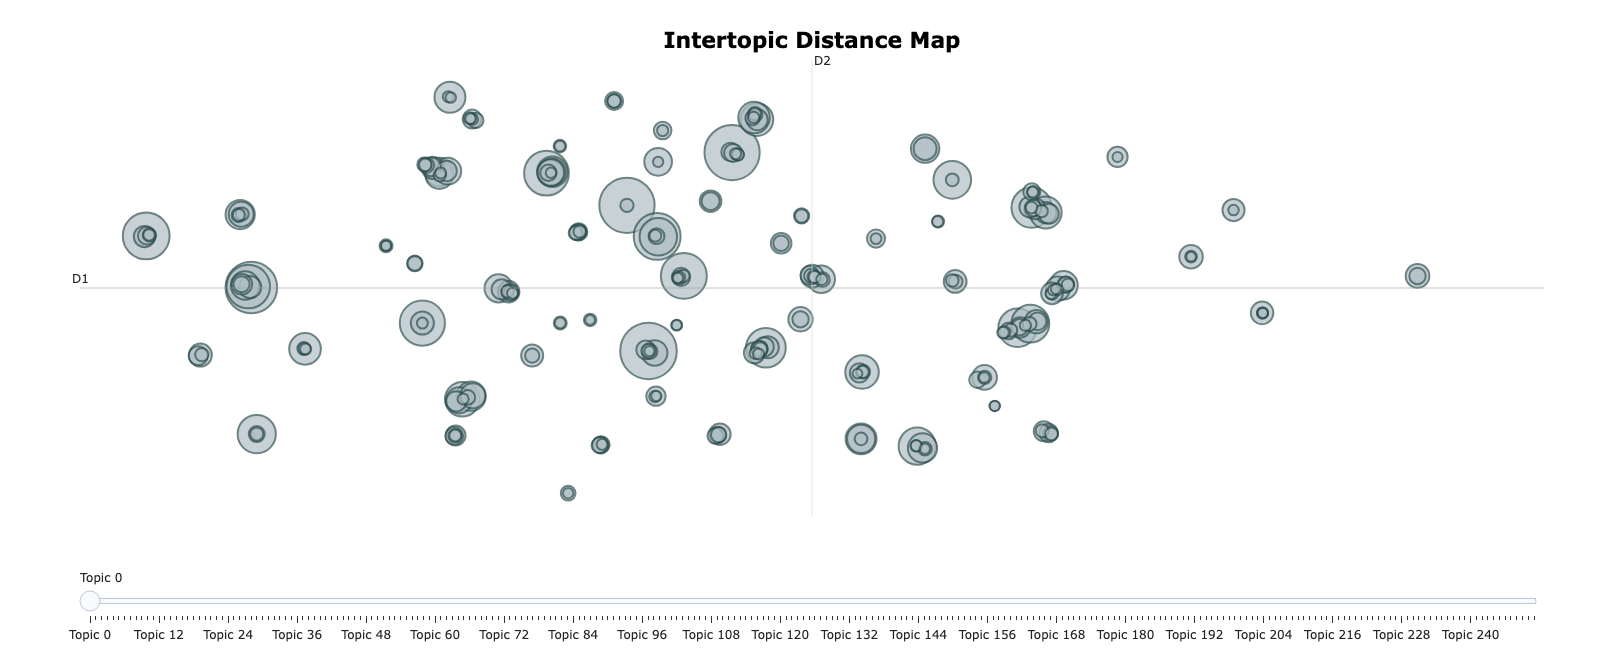

In [33]:
topic_model.visualize_topics()